In [1]:
import sys

# 推奨された方法ではない。
# 参照:https://note.com/iamhacchin/n/n8eb3efafadf9
sys.path.append("..")
from scripts.robot import *
from scipy.stats import multivariate_normal


In [2]:
class Particle:
    def __init__(self, init_pose):
        self.pose = init_pose

    def motion_update(self, nu, omega, time, noise_rate_pdf):
        # 式(5,9)の実行
        ns = noise_rate_pdf.rvs()
        # 以下2行で式(5.12)を実行
        noised_nu = (
            nu
            + ns[0] * math.sqrt(abs(nu) / time)
            + ns[1] * math.sqrt(abs(omega) / time)
        )
        noised_omega = (
            omega
            + ns[2] * math.sqrt(abs(nu) / time)
            + ns[3] * math.sqrt(abs(omega) / time)
        )

        # ノイズを加えた速度、角速度をstate_transitionに入力し、姿勢を更新
        self.pose = IdealRobot.state_transition(
            noised_nu, noised_omega, time, self.pose
        )


In [3]:
class Mcl:
    def __init__(
        self,
        init_pose,
        num,
        motion_noise_stds={"nn": 0.19, "no": 0.001, "on": 0.13, "oo": 0.2},
    ):
        # 初期位置が同じパーティクルobjectをnum個生成
        self.particles = [Particle(init_pose) for i in range(num)]

        # motion_noise_stdsは式(5.9)のσabに対応する
        v = motion_noise_stds
        # np.diagは与えられたリストの要素を対角成分に持つ対角行列を作って返す。
        c = np.diag([v["nn"] ** 2, v["no"] ** 2, v["on"] ** 2, v["oo"] ** 2])
        # 式(5.9)用の正規分布を用意。共分散行列のみ与える。平均はデフォルト0なのでそのまま。
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)

    def motion_update(self, nu, omega, time):
        # 各パーティクルのmotion_updateメソッドを呼び出す
        for p in self.particles:
            p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)

    def draw(self, ax, elems):
        # particleのx座標
        xs = [p.pose[0] for p in self.particles]
        # particleのy座標
        ys = [p.pose[1] for p in self.particles]
        # particleの向きを矢印として描画するための要素x,y
        vxs = [math.cos(p.pose[2]) for p in self.particles]
        vys = [math.sin(p.pose[2]) for p in self.particles]

        elems.append(ax.quiver(xs, ys, vxs, vys, color="blue", alpha=0.5))


In [4]:
class EstimationAgent(Agent):
    def __init__(self, time_interval, nu, omega, estimator):
        super().__init__(nu, omega)
        self.estimator = estimator
        self.time_interval = time_interval

        self.prev_nu = 0.0
        self.prev_omega = 0.0

    def decision(self, observation=None):
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        return self.nu, self.omega

    def draw(self, ax, elems):
        self.estimator.draw(ax, elems)


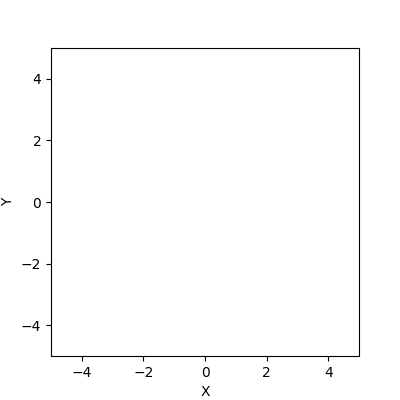

In [5]:
time_interval = 0.1  ###draw_mcl7###
world = World(30, time_interval, debug=False) 

initial_pose = np.array([0, 0, 0]).T
estimator = Mcl(initial_pose, 100)
circling = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, estimator)
r = Robot(initial_pose, sensor=None, agent=circling, color="red" )
world.append(r)

%matplotlib widget
world.draw()

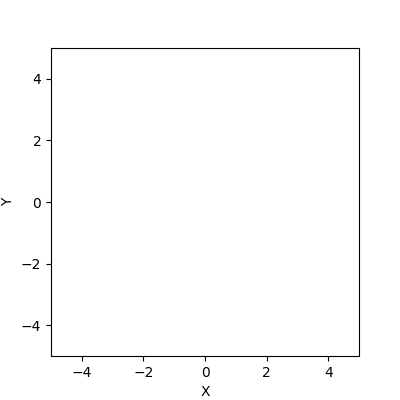

In [6]:
time_interval = 0.1  ###draw_mcl7###
world = World(30, time_interval) 

for i in range(100):
    r = Robot(np.array([0, 0, 0]).T, sensor=None, agent=Agent(0.2, 10.0/180*math.pi), color="gray" )
    world.append(r)
%matplotlib widget
world.draw()